# Feature Engineering, Singular Value Decomposition, and Principal Componenets Analysis in R

**April 2018**

### **Author:** Lauren Washington

The largest part of the Data Scientist role is data cleaning, manipulation, and engineering. Once you do the basic cleaning of your data (imputing/removing missing values, removing duplicates, changing data types)-- it's good to do feature engineering. There are multiple ways to approach this Data Science task. Some things we will focus on in this post are how to create new features from existing features, change categorical data into binary/dummy variables, transform non-normal data into normal, and transform non-linear into linear. We will also go into an unsupervised feature selection technique known as Principal Components Analysis.

## Cleaning the Data

The data for this post is from Kaggle.com. The goal of the competition is to predict the SalePrice for a property.

**Housing Data:** https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [286]:
#install required libraries
library(ggplot2)
library(reshape2)
library(dplyr)
library(dummies)
library(car)
library(scales)
library(rpart)

In [34]:
#use multiplot function for data viz subplots 
#http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

We will start by importing both the test and train data. After performing basic cleaning we will proceed to engineer new features and then reduce the dimensionality of our feature set. Feature engineering involves creativity and the fetures you create during your first run may not be enough to get the desired accuracy. This is fine as data science is an iterative process. In this post I will take you through recoding and operationalizing your features, changing variable types, interacting terms, transforming to normally distributed data, creating linear transformations, interacting terms, utilizing Singular Value Decomposition, and Principal Components Analysis. We will conclude this post with a comparison of accuracy results for the different sets of training data.

In [239]:
#import data
housing <- read.csv("train.csv")
test <- read.csv("test.csv")

In [240]:
#compare number of features and makes sure test has one less (minus the target)
cat("The training data has", ncol(housing), "features. The testing set has", ncol(test), "features.")

The training data has 81 features. The testing set has 80 features.

In [246]:
#view first 6 lines of training data
head(housing)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [248]:
head(test)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,⋯,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81,14267,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74,13830,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,MnPrv,NA,0,3,2010,WD,Normal
1464,60,RL,78,9978,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,6,2010,WD,Normal
1465,120,RL,43,5005,Pave,NA,IR1,HLS,AllPub,⋯,144,0,NA,NA,NA,0,1,2010,WD,Normal
1466,60,RL,75,10000,Pave,NA,IR1,Lvl,AllPub,⋯,0,0,NA,NA,NA,0,4,2010,WD,Normal


In [250]:
#combine test and control for cleaning
combined_train_test <- housing 
combined_train_test$SalePrice <- NULL
combined_train_test <- rbind(combined_train_test, test)

In [261]:
#check for duplicate values
sum(duplicated(housing) == TRUE)

[1] 0

In [262]:
#check data for missing values

#NAs in LotFrontage(259), Alley(1369), MasVnrType(8), MasVanArea(8), BsmtQual(37), BsmtCond(37), BsmtExposure(38),
#BsmtFinType1(37), BsmtFinType2(38), Electrical(1), GarageType(81), GarageYrBlt(81), 
#GarageFinish(81), GarageQual(81), GarageCond(81), Fence(1179), MiscFeature(1406)
summary(housing)

       Id           MSSubClass       MSZoning     LotFrontage    
 Min.   :   1.0   Min.   : 20.0   C (all):  10   Min.   : 21.00  
 1st Qu.: 365.8   1st Qu.: 20.0   FV     :  65   1st Qu.: 59.00  
 Median : 730.5   Median : 50.0   RH     :  16   Median : 69.00  
 Mean   : 730.5   Mean   : 56.9   RL     :1151   Mean   : 70.05  
 3rd Qu.:1095.2   3rd Qu.: 70.0   RM     : 218   3rd Qu.: 80.00  
 Max.   :1460.0   Max.   :190.0                  Max.   :313.00  
                                                 NA's   :259     
    LotArea        Street      Alley      LotShape  LandContour  Utilities   
 Min.   :  1300   Grvl:   6   Grvl:  50   IR1:484   Bnk:  63    AllPub:1459  
 1st Qu.:  7554   Pave:1454   Pave:  41   IR2: 41   HLS:  50    NoSeWa:   1  
 Median :  9478               NA's:1369   IR3: 10   Low:  36                 
 Mean   : 10517                           Reg:925   Lvl:1311                 
 3rd Qu.: 11602                                                              
 Max

In [263]:
#drop Alley, Fence, and Misc Features for having too many missing values
housing$Alley <- NULL
housing$Fence <- NULL
housing$MiscFeature <- NULL

In [264]:
#create numeric subset of data for basic correlations
numeric_df <- housing[sapply(housing, is.numeric)]

In [265]:
cor_matrix <- cor(numeric_df, use = "pairwise.complete.obs")
cor_matrix

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,WoodDeckSF,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000e+00,0.011156478,-0.010600689,-0.033225519,-0.02836475,0.012608925,-0.012712715,-0.021997642,-0.050297795,-0.005024049,⋯,-0.029643197,-0.0004769113,0.002889218,-0.0466347889,0.001330209,0.057043905,-0.0062424048,0.021172177,0.000711794,-0.02191672
MSSubClass,1.115648e-02,1.000000000,-0.386346885,-0.139781082,0.03262771,-0.059315817,0.027850137,0.040581045,0.022936286,-0.069835749,⋯,-0.012579358,-0.0061001212,-0.012036622,-0.0438245492,-0.026030177,0.008282708,-0.0076832913,-0.013584643,-0.021407038,-0.08428414
LotFrontage,-1.060069e-02,-0.386346885,1.000000000,0.426095019,0.25164578,-0.059213450,0.123349467,0.088865572,0.193458061,0.233633167,⋯,0.088520933,0.1519722277,0.010700337,0.0700292277,0.041382791,0.206166775,0.0033675566,0.011199955,0.007449589,0.35179910
LotArea,-3.322552e-02,-0.139781082,0.426095019,1.000000000,0.10580574,-0.005636270,0.014227652,0.013788427,0.104159822,0.214103131,⋯,0.171697687,0.0847738088,-0.018339734,0.0204228296,0.043160378,0.077672392,0.0380676920,0.001204988,-0.014261407,0.26384335
OverallQual,-2.836475e-02,0.032627708,0.251645775,0.105805742,1.00000000,-0.091932343,0.572322769,0.550683924,0.411875667,0.239665966,⋯,0.238923392,0.3088188234,-0.113936859,0.0303705671,0.064886360,0.065165844,-0.0314062105,0.070815172,-0.027346708,0.79098160
OverallCond,1.260892e-02,-0.059315817,-0.059213450,-0.005636270,-0.09193234,1.000000000,-0.375983196,0.073741498,-0.128101199,-0.046230856,⋯,-0.003333699,-0.0325888135,0.070356184,0.0255036600,0.054810529,-0.001984942,0.0687768061,-0.003510839,0.043949746,-0.07785589
YearBuilt,-1.271272e-02,0.027850137,0.123349467,0.014227652,0.57232277,-0.375983196,1.000000000,0.592854976,0.315707062,0.249503197,⋯,0.224880142,0.1886858400,-0.387267783,0.0313545131,-0.050364435,0.004949728,-0.0343831387,0.012398471,-0.013617680,0.52289733
YearRemodAdd,-2.199764e-02,0.040581045,0.088865572,0.013788427,0.55068392,0.073741498,0.592854976,1.000000000,0.179618371,0.128450547,⋯,0.205725920,0.2262976327,-0.193919147,0.0452858098,-0.038740011,0.005829372,-0.0102862488,0.021490002,0.035743247,0.50710097
MasVnrArea,-5.029780e-02,0.022936286,0.193458061,0.104159822,0.41187567,-0.128101199,0.315707062,0.179618371,1.000000000,0.264736265,⋯,0.159718134,0.1257027967,-0.110203834,0.0187955153,0.061465543,0.011723061,-0.0298153936,-0.005964716,-0.008201031,0.47749305
BsmtFinSF1,-5.024049e-03,-0.069835749,0.233633167,0.214103131,0.23966597,-0.046230856,0.249503197,0.128450547,0.264736265,1.000000000,⋯,0.204306145,0.1117606134,-0.102303306,0.0264505062,0.062020623,0.140491286,0.0035714735,-0.015726948,0.014358922,0.38641981


In [267]:
#reassign the lower diagonal of the correlation matrix to NA
cor_matrix[lower.tri(cor_matrix, diag = TRUE)] <- NA  
#melt and subset correlation matrix
cor_matrix <- subset(melt(cor_matrix, na.rm = TRUE), value > .50)   
#look at the most highly correlated features
cor_matrix

,Var1,Var2,value
233,OverallQual,YearBuilt,0.5723228
271,OverallQual,YearRemodAdd,0.5506839
273,YearBuilt,YearRemodAdd,0.5928550
461,OverallQual,TotalBsmtSF,0.5378085
466,BsmtFinSF1,TotalBsmtSF,0.5223961
507,TotalBsmtSF,X1stFlrSF,0.8195300
613,OverallQual,GrLivArea,0.5930074
622,X1stFlrSF,GrLivArea,0.5660240
623,X2ndFlrSF,GrLivArea,0.6875011
656,BsmtFinSF1,BsmtFullBath,0.6492118


In [18]:
#look at the fetures most highly correlated with the dependent variable SalePrice
subset(CM, CM[2] == 'SalePrice')

,Var1,Var2,value
1411,OverallQual,SalePrice,0.7909816
1413,YearBuilt,SalePrice,0.5228973
1414,YearRemodAdd,SalePrice,0.5071010
1419,TotalBsmtSF,SalePrice,0.6135806
1420,X1stFlrSF,SalePrice,0.6058522
1423,GrLivArea,SalePrice,0.7086245
1426,FullBath,SalePrice,0.5606638
1430,TotRmsAbvGrd,SalePrice,0.5337232
1433,GarageCars,SalePrice,0.6404092
1434,GarageArea,SalePrice,0.6234314


# Feature Engineering

## Recoding Variables to Align with Research Problem

To start, I would like to highlight the act of recoding variables to align with your paryicular research problem. We won't be doing this particular step in this analysis but it is still worth highloghting. 

Features may be represented in different units than the research question. For example, maybe you have data in centimeters but the question uses feet. It could be useful to transform the feature into something easily transferrable to the desired solution. 

You may also have features with ambiguous names which you are using to measure things such as level of exercise, quality of sleep, level of anxiety, etc. To make it easier to interpret the results from the analysis, it is sometimes helpful to recode things on an ordinal scale to imply an increase in a particular category. 

## Changing Variable Types

Sometimes you may want to transform a continuous variable into categorical. For instance, maybe you want a feature indicating if a property has >= the median square footage of all properties in the population. 

In [270]:
combined_train_test$sqft_greater_median = ifelse(combined_train_test$X1stFlrSF >= 1087, 1, 0)

In [282]:
cat(percent(round(sum(combined_train_test$sqft_greater_median == 1) / nrow(combined_train_test), 3)), 
    "percent of properties have a 1st floor sqft >= to the median value of", median(combined_train_test$X1stFlrSF),".")


49.7% percent of properties have a 1st floor sqft >= to the median value of 1082 .

## Categorical Variables

Sometimes you may want to make additional features from the current categorical variables. You can do this by creating additional categories such as partOfTown (based on the neighborhood column). The part of town feature could indicate if a neighborhood is in the north, south, east, west, etc side of town.

Or we could do a binary variabe indicating if a house was remodeled within the last decade.  

We could also create dummy variables of our categorical variables. Creating dummy variables of a category creates n- 1 new binary features. One factor level is removed and considered the reference group as inference is possible based on the results of the other factor levels. For example, if Neighborhood is turned into a dummy variable and all of the factor levels = 0 then we can conclude that the refernce level is equal to 1. Also, if 1 is already present then we can conclude the reference is equal to 0. Another added bonus to creating dummy variables is the conversion from factor to numeric. As you can see, we are only able to produce correlation results on numeric data. This is true for a good amount of Machine Learning algorithms, as well. Creating dummy variables will make your life easier, as a data scientist, and will provide deeper insights into the micro level correlations found within a category.

In [54]:
housing_w_dummy_vars <- cbind(housing, dummy(housing$full_bath_tot_rms_abv_grd_avg, sep = "_"))

In [63]:
# create 2 new training data I. all four features II.just > .80 correlation

cor_dum <- cor(housing_w_dummy_vars[sapply(housing_w_dummy_vars, is.numeric)], use = "pairwise.complete.obs")
cor_dum

Warning message in cor(housing_w_dummy_vars[sapply(housing_w_dummy_vars, is.numeric)], :
“the standard deviation is zero”

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,NA_3.5,NA_4,NA_4.5,NA_5,NA_5.5,NA_6,NA_6.5,NA_7,NA_7.5,NA_8
Id,1.000000e+00,0.011156478,-0.010600689,-0.03322552,-0.02836475,0.012608925,-0.01271272,-0.02199764,-0.05029780,-0.005024049,⋯,0.010162873,-0.0089608090,0.03351383,-0.0023636907,-0.0053191646,-0.030591742,0.0220340316,0.025938765,0.0377127313,-0.0058700531
MSSubClass,1.115648e-02,1.000000000,-0.386346885,-0.13978108,0.03262771,-0.059315817,0.02785014,0.04058104,0.02293629,-0.069835749,⋯,-0.012390903,0.0294877616,-0.04127074,0.0177498693,0.0292197541,0.071189566,0.0245729210,0.029963844,0.0007471051,0.0824065820
LotFrontage,-1.060069e-02,-0.386346885,1.000000000,0.42609502,0.25164578,-0.059213450,0.12334947,0.08886557,0.19345806,0.233633167,⋯,-0.082051533,-0.0721884055,0.05769402,0.1409440091,0.1508674128,0.089952517,0.0813071331,0.162230847,0.0546529502,-0.0119514570
LotArea,-3.322552e-02,-0.139781082,0.426095019,1.00000000,0.10580574,-0.005636270,0.01422765,0.01378843,0.10415982,0.214103131,⋯,-0.039741136,-0.0556930865,0.06750574,0.0638458045,0.0576178940,0.039502631,0.0599096861,0.082434374,0.0788611795,0.0009948823
OverallQual,-2.836475e-02,0.032627708,0.251645775,0.10580574,1.00000000,-0.091932343,0.57232277,0.55068392,0.41187567,0.239665966,⋯,-0.197192322,0.0739525199,0.19640224,0.1558715699,0.1512944998,0.150576572,0.1168935130,0.115506340,0.0436247971,-0.0018806812
OverallCond,1.260892e-02,-0.059315817,-0.059213450,-0.00563627,-0.09193234,1.000000000,-0.37598320,0.07374150,-0.12810120,-0.046230856,⋯,0.060419810,-0.0011551777,-0.08616988,-0.1029364829,0.0148995027,-0.028109108,0.0242159858,0.008364298,-0.0153292881,0.0335285488
YearBuilt,-1.271272e-02,0.027850137,0.123349467,0.01422765,0.57232277,-0.375983196,1.00000000,0.59285498,0.31570706,0.249503197,⋯,-0.131157328,0.0669621343,0.16649498,0.1159897313,0.0517931621,0.007343533,-0.0360662636,0.015293964,0.0216690683,-0.0496572878
YearRemodAdd,-2.199764e-02,0.040581045,0.088865572,0.01378843,0.55068392,0.073741498,0.59285498,1.00000000,0.17961837,0.128450547,⋯,-0.139004115,0.0555257829,0.16572732,0.1005391761,0.0991781161,0.024970169,0.0464916791,0.033574092,0.0282771399,0.0128555055
MasVnrArea,-5.029780e-02,0.022936286,0.193458061,0.10415982,0.41187567,-0.128101199,0.31570706,0.17961837,1.00000000,0.264736265,⋯,-0.091998880,0.0139808888,0.07180994,0.0797411954,0.0952746309,0.087695015,0.1348865101,0.125975895,0.0578032491,-0.0150381884
BsmtFinSF1,-5.024049e-03,-0.069835749,0.233633167,0.21410313,0.23966597,-0.046230856,0.24950320,0.12845055,0.26473626,1.000000000,⋯,0.044793712,-0.0436818584,-0.01231293,-0.0237264008,0.0098033787,0.015481810,0.0434822433,0.116771975,0.0167678299,-0.0107742655


In [64]:
cor_dum[lower.tri(cor_dum, diag = TRUE)] <- NA  
#melt and subset correlation matrix
cor_dum <- subset(melt(cor_dum, na.rm = TRUE), value > .00)   
#look at the features highly correlated with the dependent feature
cor_dum <- subset(cor_dum, cor_dum[1] == 'SalePrice' | cor_dum[2] == 'SalePrice')
cor_dum

,Var1,Var2,value
2519,LotFrontage,SalePrice,0.351799097
2520,LotArea,SalePrice,0.263843354
2521,OverallQual,SalePrice,0.790981601
2523,YearBuilt,SalePrice,0.522897333
2524,YearRemodAdd,SalePrice,0.507100967
2525,MasVnrArea,SalePrice,0.477493047
2526,BsmtFinSF1,SalePrice,0.386419806
2528,BsmtUnfSF,SalePrice,0.214479106
2529,TotalBsmtSF,SalePrice,0.613580552
2530,X1stFlrSF,SalePrice,0.605852185


## Correlated Variables

There are also ways to prevent including redundant information in your model. If during the Exploratory Data Analysis phase you discover that pairs of variables are highly correlated and tell similar information then you can choose to create a new feature by combining the two or simply drop one of the features. One way ofcombining the features is to take the average of the two features. If there are three or more features then you can also try methods of dimensionality reduction like Singular Value Decomposition or Principal Components Analysis. 

YearBuilt and YearRemodelAdd (0.5928550) Added are highly correlated , as well as TotalBsmtSF and X1stFlrSF (0.8195300), FullBath and TotRmsAbvGrd (0.5547843), and GarageCars and GarageArea (0.8824754). Instead of having highly correlated variables we could combine the features by taking the average.

In [19]:
housing$year_built_remodel_avg <- (housing$YearBuilt + housing$YearRemodAdd) / 2
housing$tot_bsmt_sf_x1st_flr_sf_avg <- (housing$TotalBsmtSF + housing$X1stFlrSF) / 2
housing$full_bath_tot_rms_abv_grd_avg <- (housing$FullBath + housing$TotRmsAbvGrd) / 2
housing$garage_cars_garage_area_avg <- (housing$GarageCars + housing$GarageArea) / 2

## Non - Normal Data

If your algorithm expects normally distributed data it is wise to check if your predictors are in fact normal. If you find that they are skewed then you can apply transformations to  our features. This can be accomplished in many ways. SOme of the common techniques are taking log, log10, absolute value, square root, or inverse a feature. Once you transform your features you can do graphical and parametric assesments to decide the best feature to choose for the model. 

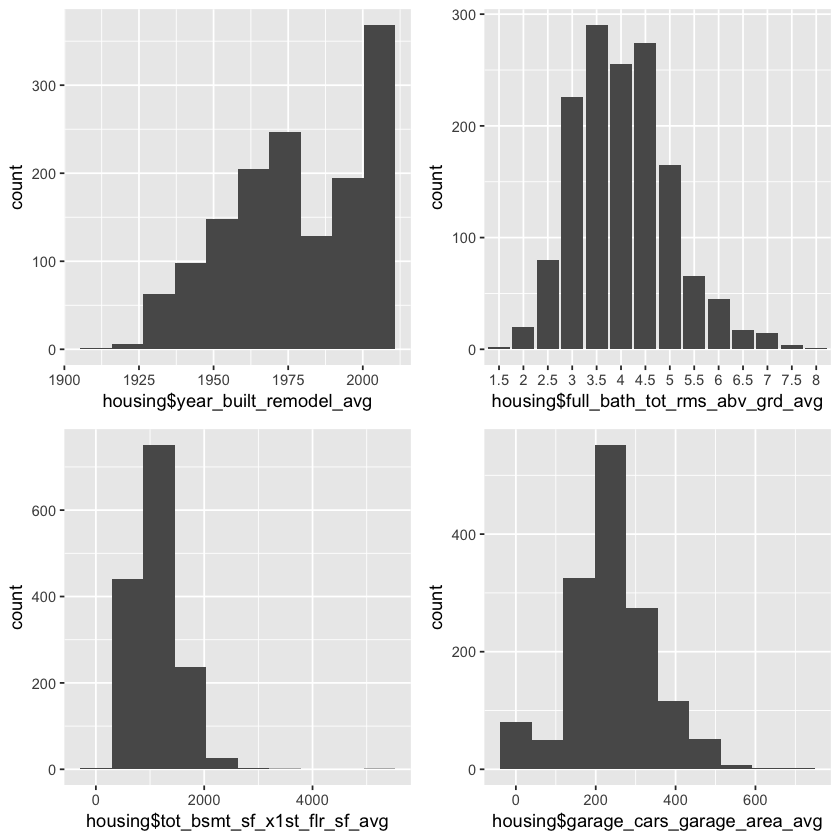

In [116]:
p1 <- ggplot(data= housing, aes(housing$year_built_remodel_avg)) + geom_histogram(bins = 10)
p2 <- ggplot(data= housing, aes(housing$tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 10)
p3 <- ggplot(data= housing, aes(housing$full_bath_tot_rms_abv_grd_avg)) + geom_bar()
p4 <- ggplot(data= housing, aes(housing$garage_cars_garage_area_avg)) + geom_histogram(bins = 10)
multiplot(p1, p2, p3, p4, cols=2)

In [89]:
#The ANOVA
year_built_remodel_avg_mod <-lm(SalePrice ~ year_built_remodel_avg + log_year_built_remodel_avg + log10_year_built_remodel_avg
                 + abs_year_built_remodel_avg + sqrt_year_built_remodel_avg +inverse_year_built_remodel_avg, housing) 
anova(year_built_remodel_avg_mod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
year_built_remodel_avg,1,3.056496e+12,3.056496e+12,757.614038,1.258458e-134
log_year_built_remodel_avg,1,2.635907e+11,2.635907e+11,65.336266,1.315045e-15
inverse_year_built_remodel_avg,1,1.377991e+10,1.377991e+10,3.415627,6.478456e-02
Residuals,1456,5.874044e+12,4.034371e+09,NA,NA


In [90]:
#TESTING ASSUMPTIONS
#Generate residual and predicted values 
housing$year_built_remodel_avg_mod_resids <- residuals(year_built_remodel_avg_mod)
housing$year_built_remodel_avg_mod_preds <- predict(year_built_remodel_avg_mod) 
housing$year_built_remodel_avg_mod_sq_preds <- housing$preds^2

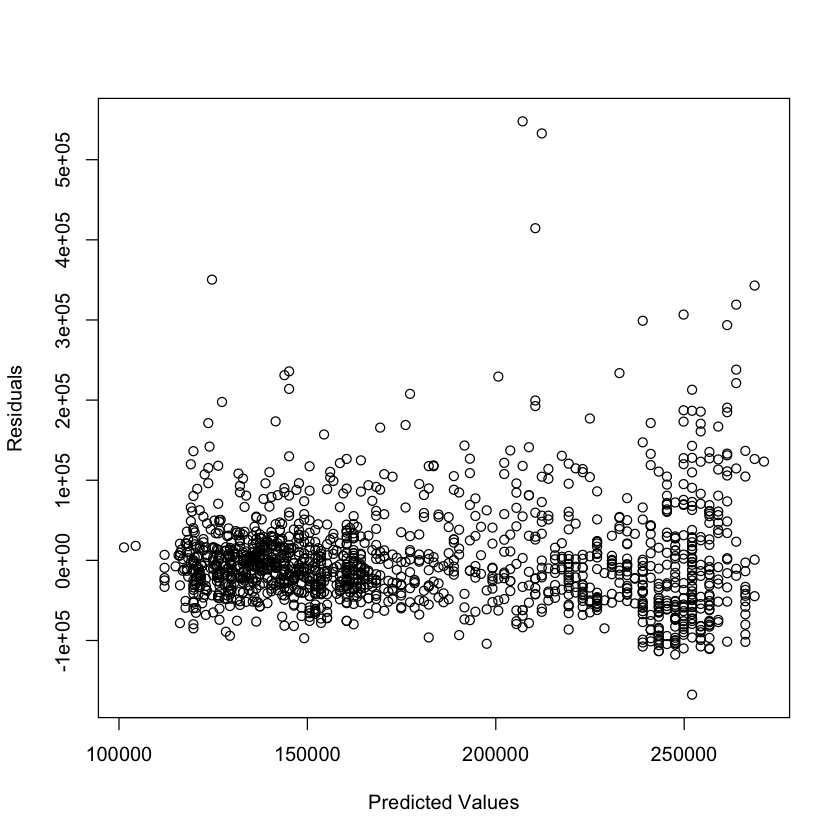

In [91]:
#Look at a plot of residual vs. predicted values
plot(year_built_remodel_avg_mod_resids ~ year_built_remodel_avg_mod_preds, data = housing, xlab = "Predicted Values",
ylab = "Residuals")

In [92]:
#Perform a Shapiro-Wilk test for normality of residuals
shapiro.test(housing$year_built_remodel_avg_mod_resids)


	Shapiro-Wilk normality test

data:  housing$year_built_remodel_avg_mod_resids
W = 0.85406, p-value < 2.2e-16


In [93]:
#Perform a Tukey 1-df Test for Non-additivity
year_built_remodel_avg_mod_log_1df_mod<-lm(SalePrice ~ year_built_remodel_avg + log_year_built_remodel_avg + log10_year_built_remodel_avg
                 + abs_year_built_remodel_avg + sqrt_year_built_remodel_avg +inverse_year_built_remodel_avg, housing) 
anova(year_built_remodel_avg_mod_log_1df_mod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
year_built_remodel_avg,1,3.056496e+12,3.056496e+12,757.614038,1.258458e-134
log_year_built_remodel_avg,1,2.635907e+11,2.635907e+11,65.336266,1.315045e-15
inverse_year_built_remodel_avg,1,1.377991e+10,1.377991e+10,3.415627,6.478456e-02
Residuals,1456,5.874044e+12,4.034371e+09,NA,NA


In [65]:
#log, square root, inverse
housing$log_year_built_remodel_avg <- log(housing$year_built_remodel_avg)
housing$log10_year_built_remodel_avg <- log10(housing$year_built_remodel_avg)
housing$exp_year_built_remodel_avg <- exp(housing$year_built_remodel_avg)
housing$abs_year_built_remodel_avg <- abs(housing$year_built_remodel_avg)
housing$sqrt_year_built_remodel_avg <- sqrt(housing$year_built_remodel_avg)
housing$inverse_year_built_remodel_avg <- 1/(housing$year_built_remodel_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

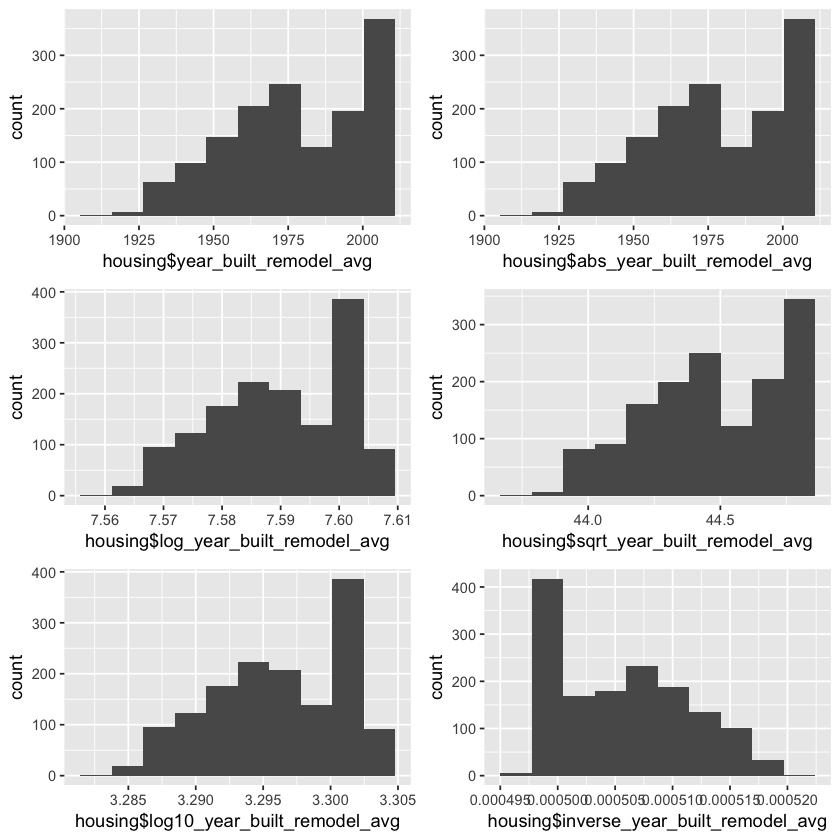

In [117]:
p5 <- ggplot(data= housing, aes(housing$log_year_built_remodel_avg)) + geom_histogram(bins = 10)
p6 <- ggplot(data= housing, aes(housing$log10_year_built_remodel_avg)) + geom_histogram(bins = 10)
p7 <- ggplot(data= housing, aes(housing$abs_year_built_remodel_avg)) + geom_histogram(bins = 10)
p8 <- ggplot(data= housing, aes(housing$sqrt_year_built_remodel_avg)) + geom_histogram(bins = 10)
p9 <- ggplot(data= housing, aes(housing$inverse_year_built_remodel_avg)) + geom_histogram(bins = 10)
multiplot(p1, p5, p6, p7,p8, p9, cols = 2)

In [94]:
#log, square root, inverse
housing$log_tot_bsmt_sf_x1st_flr_sf_avg <- log(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$log10_tot_bsmt_sf_x1st_flr_sf_avg <- log10(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$abs_tot_bsmt_sf_x1st_flr_sf_avg <- abs(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg <- sqrt(housing$tot_bsmt_sf_x1st_flr_sf_avg)
housing$inverse_tot_bsmt_sf_x1st_flr_sf_avg <- 1/(housing$tot_bsmt_sf_x1st_flr_sf_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


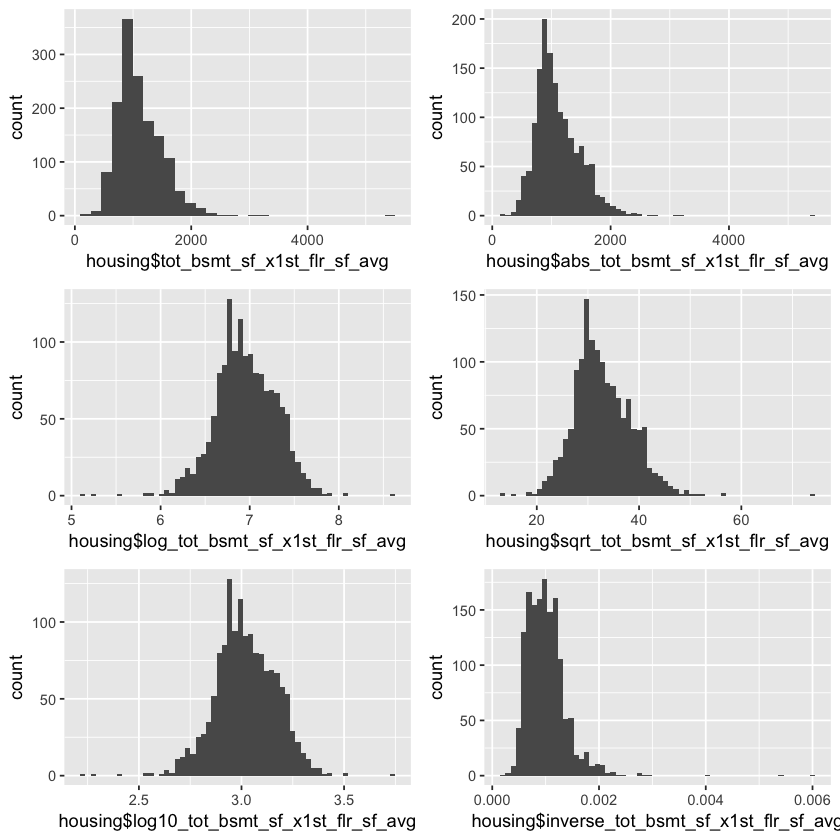

In [109]:
p10 <- ggplot(data= housing, aes(housing$log_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60)
p11 <- ggplot(data= housing, aes(housing$log10_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60)
p12 <- ggplot(data= housing, aes(housing$abs_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60)
p13 <- ggplot(data= housing, aes(housing$sqrt_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60)
p14 <- ggplot(data= housing, aes(housing$inverse_tot_bsmt_sf_x1st_flr_sf_avg)) + geom_histogram(bins = 60)
multiplot(p2, p10, p11, p12,p13, p14, cols = 2)

In [49]:
#log, square root, inverse
housing$log_garage_cars_garage_area_avg <- log(housing$garage_cars_garage_area_avg)
housing$sqrt_garage_cars_garage_area_avg <- sqrt(housing$garage_cars_garage_area_avg)
housing$inverse_garage_cars_garage_area_avg <- 1/(housing$garage_cars_garage_area_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

Warning message:
“Removed 81 rows containing non-finite values (stat_bin).”Warning message:
“Removed 81 rows containing non-finite values (stat_bin).”

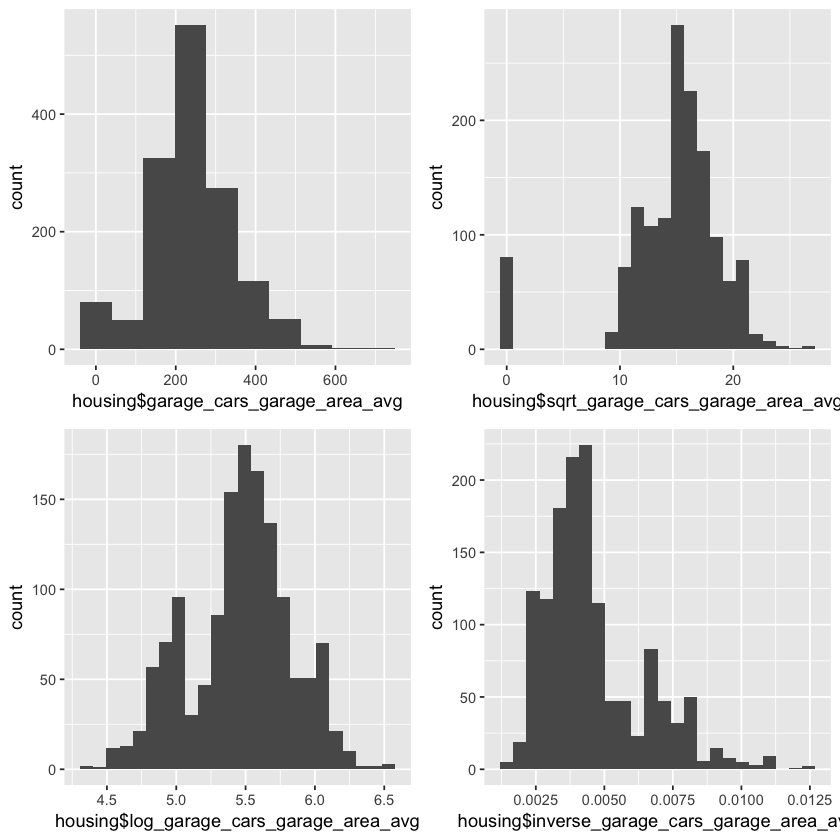

In [121]:
p11 <- ggplot(data= housing, aes(housing$log_garage_cars_garage_area_avg)) + geom_histogram(bins = 24)
p12 <- ggplot(data= housing, aes(housing$sqrt_garage_cars_garage_area_avg)) + geom_histogram(bins = 24)
p13 <- ggplot(data= housing, aes(housing$inverse_garage_cars_garage_area_avg)) + geom_histogram(bins = 24)
multiplot(p4, p11, p12, p13, cols = 2)

## Non - Linear Data

Use quadratic transformations to change non-linear data into linear if the model assumes a linear relationship between the outcome and feature variable. This can be achieved by squaring, cubing, etc. 

## Normalizing Variables

If you have data in different ranges it may be useful to normalize your data. When you normalize your data you transform your data into data points between a range (where the mean is normally 0 and standard deviation is equal to 1). 

## Interaction Terms

Sometimes there are fetures related to outcomes with dependencies on another feature. For example, lets say you think the properties with greater square footage have higher sale prices if they have additional bathrooms. This could be represented by multiplying the X1stFlrSF feature by FullBath.

## Singular Value Decomposition

In [208]:
(s <- svd(X))
D <- diag(s$d)

-0.030629385,0.0077107336,-0.002432619,1.324819e-02,0.0401241023,0.0048094441,-0.05480022,0.0221473854,-0.0005415777,0.005949212,⋯,-0.0175643963,-0.033863023,0.0041205460,0.026898069,-0.000152669,0.0260292208,-0.0210709786,0.0112964190,0.410489663,0.562588032
-0.026681409,-0.0017996043,-0.009940883,-3.817489e-02,0.0105070213,0.0030977687,-0.05258235,0.0089904056,0.0042472776,-0.011045420,⋯,0.0063930455,0.024802924,-0.0565702301,-0.059349769,0.043165217,0.0001355935,-0.0935093489,0.0040495335,0.630559385,-0.143728682
-0.032848343,0.0001493371,0.004036710,2.349494e-02,0.0222054349,0.0005169773,-0.05289329,0.0197954502,0.0003406345,0.003648743,⋯,0.0067324530,0.032346793,0.0162586229,0.045486039,-0.017384267,0.0317818746,-0.0234811236,-0.0152411352,-0.439324506,0.477329872
-0.020599777,-0.0095712574,-0.023491066,2.813104e-02,0.0095507812,0.0230686040,-0.05258719,-0.0033691469,-0.0075240658,-0.003548249,⋯,0.0169439503,0.027362653,0.0179945206,0.068186613,0.066280851,-0.0768643868,-0.0100219815,0.0187716294,0.021590715,-0.039317374
-0.036754820,-0.0060249079,0.012921455,2.540921e-02,0.0229639273,0.0277821177,-0.04999353,0.0202693649,-0.0129293793,0.014245810,⋯,0.0010452341,0.014507648,0.0248482561,0.037059145,0.007414779,-0.0070520229,-0.0025479152,0.0163522748,0.206358670,-0.345955146
-0.021072632,-0.0260120144,-0.016251183,8.122175e-04,0.0371359241,0.0018650856,-0.05453937,0.0242732866,0.0398348849,-0.105787418,⋯,0.0322702534,-0.088647691,0.0197521425,0.025474735,0.028977280,-0.0159675561,0.0143510337,-0.0060549663,0.007629123,0.092108346
-0.045076526,0.0204834076,0.026740360,-5.324184e-02,0.0109797288,0.0012620396,-0.04869728,-0.0003958454,-0.0023426554,-0.012054624,⋯,-0.0191601115,0.025244498,-0.0073686586,-0.002779445,-0.033808729,0.0112796299,0.0104834675,-0.0142669027,0.201215674,0.134793858
-0.019094646,0.0012719013,-0.030954816,3.376445e-02,-0.0154593538,0.0370661384,-0.04991726,0.0044771222,0.0083253500,-0.002258134,⋯,0.0686205460,-0.025890589,-0.0991858885,0.023709891,0.031391316,0.0086453739,-0.0186872832,-0.1557862537,0.043416786,0.088174564
-0.017359468,-0.0058504999,-0.029656544,-3.322540e-02,0.0181977950,0.0070012947,-0.05387703,0.0057189795,0.0013878674,-0.009692056,⋯,0.0650540690,0.041230240,-0.0217329192,0.034235022,0.002711819,-0.0039269267,0.0022136169,-0.1441027380,-0.106847587,0.005085970
-0.019072684,-0.0177417528,-0.022764508,-3.440995e-02,0.0185190467,-0.0007225648,-0.05404012,0.0170806683,-0.0002586213,-0.007200079,⋯,-0.0355310345,0.016518680,0.0175970862,0.021843171,-0.036884800,-0.0027320507,-0.0015162978,-0.0056808806,-0.153961378,-0.425789471
-0.050658459,0.0209700360,0.041256900,1.703680e-02,0.0476238408,0.0031729406,-0.04951098,0.0139442201,0.0005358690,0.001601494,⋯,0.0207650659,0.033830145,-0.0866321162,0.040827645,-0.001487714,-0.0229886835,-0.0008803962,0.0249692420,0.032260669,0.198435304


In [209]:
s$u %*% D %*% t(s$v) #  X = U D V'

1,60,65,8450,7,5,2003,2003,1.960000e+02,7.060000e+02,⋯,6.978139e-12,6.100000e+01,1.215370e-12,2.481630e-13,8.572566e-13,4.717763e-13,1.910966e-12,2,2008,208500
2,20,80,9600,6,8,1976,1976,1.965608e-12,9.780000e+02,⋯,2.980000e+02,6.723580e-13,-4.230181e-13,1.453928e-13,-1.806434e-13,-1.672996e-13,4.299527e-13,5,2007,181500
3,60,68,11250,7,5,2001,2002,1.620000e+02,4.860000e+02,⋯,-1.035428e-13,4.200000e+01,-2.083450e-13,-2.285397e-14,8.460295e-14,-4.488459e-14,7.726150e-14,9,2008,223500
4,70,60,9550,7,5,1915,1970,2.077957e-13,2.160000e+02,⋯,4.052080e-13,3.500000e+01,2.720000e+02,-1.686721e-13,-1.367701e-13,1.581985e-13,2.465039e-13,2,2006,140000
5,60,84,14260,8,5,2000,2000,3.500000e+02,6.550000e+02,⋯,1.920000e+02,8.400000e+01,-3.013546e-14,-4.134149e-13,4.278990e-14,1.827341e-13,-5.232251e-14,12,2008,250000
6,50,85,14115,5,5,1993,1995,4.621529e-13,7.320000e+02,⋯,4.000000e+01,3.000000e+01,1.692452e-13,3.200000e+02,-1.135261e-13,-2.713592e-13,7.000000e+02,10,2009,143000
7,20,75,10084,8,5,2004,2005,1.860000e+02,1.369000e+03,⋯,2.550000e+02,5.700000e+01,-3.455834e-13,2.920849e-13,-2.487509e-13,3.049538e-14,9.462070e-14,8,2007,307000
9,50,51,6120,7,5,1931,1950,-6.700551e-13,2.770990e-11,⋯,9.000000e+01,-1.781548e-14,2.050000e+02,-7.705212e-14,-4.345345e-14,-8.448773e-14,3.045162e-13,4,2008,129900
10,190,50,7420,5,6,1939,1950,-4.506874e-13,8.510000e+02,⋯,2.181655e-13,4.000000e+00,1.899357e-13,7.335585e-14,4.777958e-14,-1.426208e-14,6.670189e-13,1,2008,118000
11,20,70,11200,5,5,1965,1965,-8.163029e-14,9.060000e+02,⋯,1.013354e-12,1.387088e-13,1.762442e-13,1.324676e-13,6.255875e-14,-8.178088e-14,4.288418e-13,2,2008,129500
12,60,85,11924,9,5,2005,2006,2.860000e+02,9.980000e+02,⋯,1.470000e+02,2.100000e+01,-3.612453e-13,2.822439e-14,-2.501476e-13,-2.103065e-13,-4.129152e-13,7,2006,345000


In [216]:
#same as above
A = s$u %*% diag(s$d)  %*% t(s$v)
A

## Principal Components Analysis



In [129]:
#principal component analysis
prin_comp <- prcomp(na.omit(numeric_df), scale. = T)
names(prin_comp)

[1] "sdev"     "rotation" "center"   "scale"    "x"

In [284]:
#outputs the mean of variables
prin_comp$center

Id    MSSubClass   LotFrontage       LotArea   OverallQual 
 7.268421e+02  5.614630e+01  7.066548e+01  1.012296e+04  6.212310e+00 
  OverallCond     YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1 
 5.561106e+00  1.972265e+03  1.985683e+03  1.084880e+02  4.383996e+02 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF 
 4.458965e+01  5.941258e+02  1.077115e+03  1.173584e+03  3.532587e+02 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
 4.568243e+00  1.531411e+03  4.139161e-01  5.530776e-02  1.580731e+00 
     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces 
 3.818020e-01  2.864407e+00  1.042819e+00  6.576271e+00  6.039251e-01 
  GarageYrBlt    GarageCars    GarageArea    WoodDeckSF   OpenPorchSF 
 1.978400e+03  1.878680e+00  5.029554e+02  9.261017e+01  4.613024e+01 
EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea       MiscVal 
 2.184478e+01  3.348796e+00  1.610080e+01  2.934880e+00  2.342908e+01 
       MoSold        YrSold     SalePrice 
 6.339875e+00  2.007796e+03  1.855062e+05

In [285]:
#outputs the standard deviation of variables
prin_comp$scale

Id    MSSubClass   LotFrontage       LotArea   OverallQual 
 4.207690e+02  4.177268e+01  2.426681e+01  8.129303e+03  1.380822e+00 
  OverallCond     YearBuilt  YearRemodAdd    MasVnrArea    BsmtFinSF1 
 1.068236e+00  3.096773e+01  2.102597e+01  1.895010e+02  4.683850e+02 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF     X1stFlrSF     X2ndFlrSF 
 1.578287e+02  4.502597e+02  4.456565e+02  3.861743e+02  4.385618e+02 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
 4.159547e+01  5.237239e+02  5.122978e-01  2.325536e-01  5.501167e-01 
     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd    Fireplaces 
 4.987384e-01  7.719351e-01  2.069004e-01  1.591195e+00  6.325563e-01 
  GarageYrBlt    GarageCars    GarageArea    WoodDeckSF   OpenPorchSF 
 2.582283e+01  6.543129e-01  1.912430e+02  1.218686e+02  6.439003e+01 
EnclosedPorch    X3SsnPorch   ScreenPorch      PoolArea       MiscVal 
 6.128208e+01  2.977254e+01  5.780183e+01  4.022209e+01  1.657598e+02 
       MoSold        YrSold     SalePrice 
 2.687854e+00  1.335043e+00  8.299916e+04

In [131]:
prin_comp$rotation

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38
Id,0.011307430,0.0182981366,-0.0096190754,0.01203912,-0.0847353911,3.087160e-01,-0.1403254179,0.135342675,0.30680279,-1.400133e-01,⋯,0.022690855,0.004167212,0.009187560,-0.033648950,0.005943922,0.012081806,0.0142943115,-0.0085309555,-1.027167e-16,0.000000e+00
MSSubClass,0.019118181,0.1777572845,0.2109790130,0.32851245,-0.2495517932,1.634048e-01,0.1440235892,0.059874463,-0.24749364,-8.855977e-02,⋯,-0.025759691,0.145729440,0.101107794,0.072857930,-0.119909099,-0.027203066,0.0755390219,0.0312359563,3.487175e-17,3.291701e-16
LotFrontage,-0.155739939,0.0001661163,-0.2885448317,-0.18724244,0.0030067903,-1.605796e-01,-0.1313192320,-0.089404835,0.19758477,3.028361e-02,⋯,0.003104819,-0.029248781,-0.009261217,0.001354830,-0.050662280,-0.034642823,-0.0057885842,0.0777299884,-1.519540e-16,-1.667408e-16
LotArea,-0.115376876,-0.0111279656,-0.2859730729,-0.05339940,0.0172160859,-1.395272e-01,-0.0954546120,-0.087528643,0.23708097,1.030769e-01,⋯,0.046675089,0.043448986,0.021645280,0.002588328,0.048215594,-0.016845226,-0.0074425959,-0.0196097659,2.417568e-16,-1.007845e-17
OverallQual,-0.288091441,-0.0179550346,0.0930244646,0.01554352,0.1425969556,7.924032e-03,0.0180641781,-0.026410718,-0.13885502,-2.774408e-02,⋯,0.560659930,0.197094395,0.149491833,-0.171324944,0.518679590,0.085695695,-0.0791917245,0.0607161734,-3.624280e-16,6.925780e-16
OverallCond,0.094088763,0.0611201444,-0.1555577634,0.03572670,0.3941804878,-1.252672e-02,-0.0210212206,0.434787784,-0.13074590,1.072688e-03,⋯,0.231231919,-0.166137176,-0.162043560,0.165490362,-0.010560436,-0.082295728,-0.0737484550,-0.1418285042,1.837380e-16,-1.182256e-16
YearBuilt,-0.224563649,-0.1988823556,0.2970938213,0.09589014,-0.0004487488,-4.522488e-03,-0.0496554720,-0.050373184,0.13577911,4.541366e-03,⋯,0.219583972,-0.072399165,-0.004949061,0.095215424,-0.135886953,-0.161398972,0.0523745933,-0.7334737900,1.278957e-16,-8.202353e-17
YearRemodAdd,-0.201420013,-0.1117752820,0.2395666515,0.06540143,0.2316430254,2.427498e-02,-0.1392153199,0.210242624,-0.02108933,-1.202518e-01,⋯,-0.476458127,0.196783792,0.265287621,-0.305112954,0.020119432,0.034919501,0.1257823644,0.0914024708,1.144186e-16,-1.074944e-17
MasVnrArea,-0.188131507,-0.0048840435,-0.0057089503,0.06701659,-0.0750837352,-1.243382e-01,0.1720447350,-0.084362429,-0.22002359,2.045625e-01,⋯,-0.081252540,-0.022488530,0.010265860,0.011412626,0.063109641,-0.011363653,-0.0223921667,0.0405752251,7.050943e-18,3.923221e-17
BsmtFinSF1,-0.136653961,-0.2507549761,-0.2768788429,0.33744070,-0.1373567793,-3.632123e-02,0.1292404136,0.024507267,-0.10005283,1.335539e-02,⋯,0.065632549,-0.040417433,0.022275365,-0.250313691,-0.009040208,-0.182881414,0.0351890360,0.0651709349,-5.532094e-01,1.837237e-01


In [132]:
 prin_comp$rotation[1:5,1:4]

,PC1,PC2,PC3,PC4
Id,0.01130743,0.0182981366,-0.009619075,0.01203912
MSSubClass,0.01911818,0.1777572845,0.210979013,0.32851245
LotFrontage,-0.15573994,0.0001661163,-0.288544832,-0.18724244
LotArea,-0.11537688,-0.0111279656,-0.285973073,-0.05339940
OverallQual,-0.28809144,-0.0179550346,0.093024465,0.01554352


In [133]:
dim(prin_comp$x)

[1] 1121   38

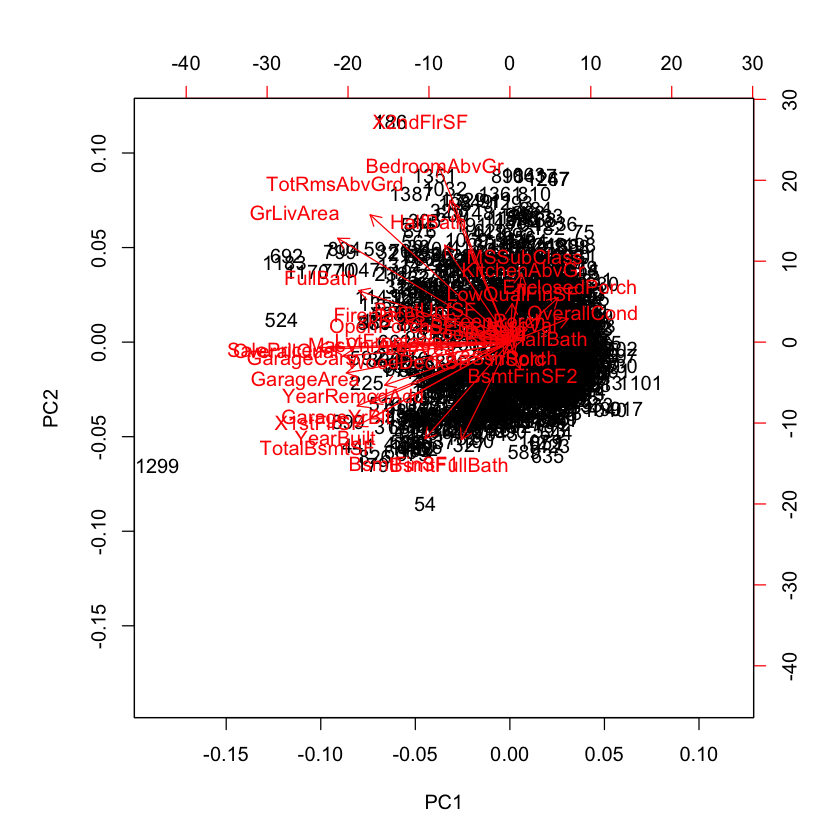

In [136]:
biplot(prin_comp, scale = 1)

In [141]:
#compute standard deviation of each principal component
std_dev <- prin_comp$sdev
#compute variance
pr_var <- std_dev^2
#check variance of first 10 components
pr_var[1:10]

[1] 8.220175 3.159216 2.706206 2.042937 1.535453 1.258399 1.223080 1.141037
 [9] 1.135404 1.106005

In [142]:
#proportion of variance explained
prop_varex <- pr_var/sum(pr_var)
prop_varex[1:20]


[1] 0.21632040 0.08313725 0.07121594 0.05376149 0.04040665 0.03311577
 [7] 0.03218631 0.03002729 0.02987905 0.02910540 0.02840630 0.02726657
[13] 0.02700844 0.02433167 0.02409108 0.02347359 0.02218440 0.02081942
[19] 0.02009689 0.01964773

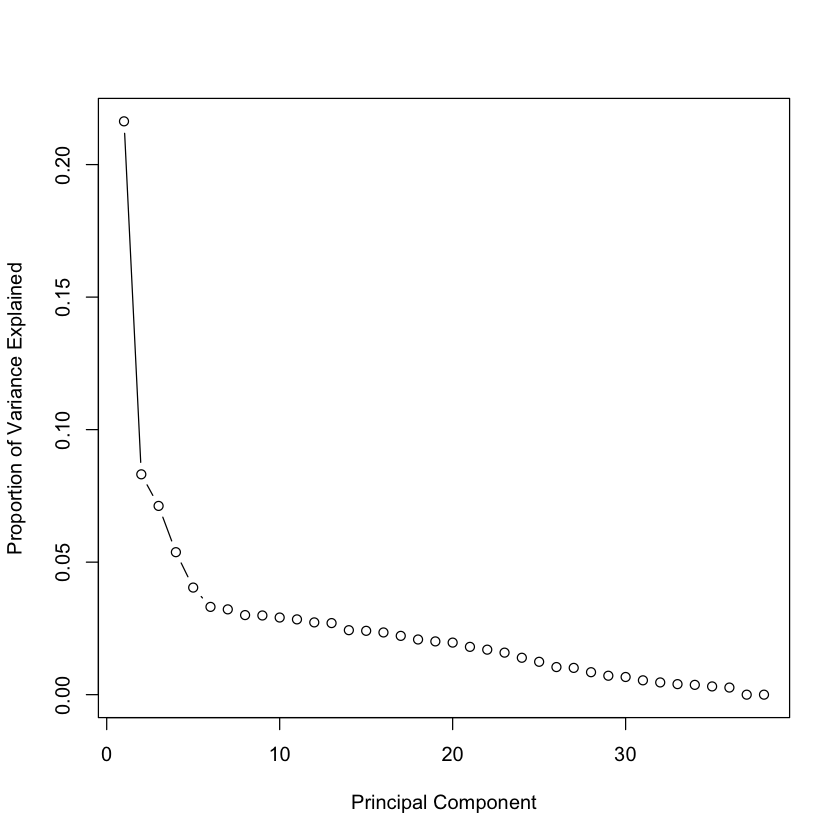

In [143]:
#scree plot
plot(prop_varex, xlab = "Principal Component",
        ylab = "Proportion of Variance Explained",
        type = "b")

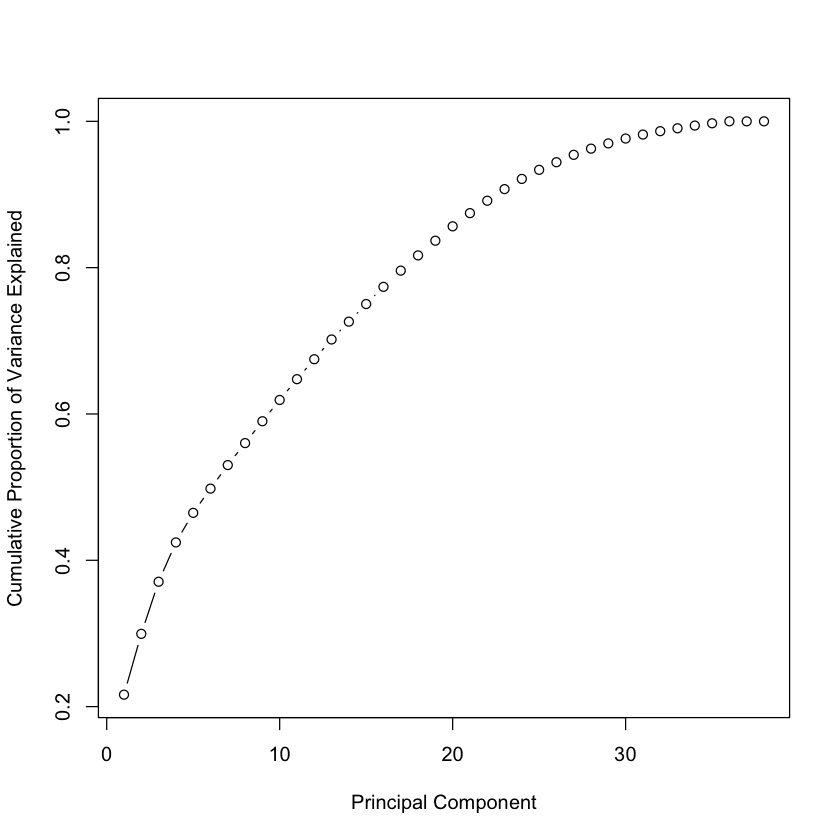

In [144]:
#cumulative scree plot
plot(cumsum(prop_varex), xlab = "Principal Component",
        ylab = "Cumulative Proportion of Variance Explained",
        type = "b")

In [167]:
sum(prop_varex[1:27])

[1] 0.9542106

In [190]:
pca_cor_matrix <- cor(na.omit(numeric_df), prin_comp$x )

In [191]:
#st the lower diagonal of the correlation matrix to NA
pca_cor_matrix[lower.tri(pca_cor_matrix, diag = TRUE)] <- NA  
#melt and subset correlation matrix
PCACM <- subset(melt(pca_cor_matrix, na.rm = TRUE), value > .00)   
#look at the features highly correlated with the dependent feature
PCACM

,Var1,Var2,value
39,Id,PC2,0.032523442
78,MSSubClass,PC3,0.347072058
115,Id,PC4,0.017207676
116,MSSubClass,PC4,0.469547236
155,LotFrontage,PC5,0.003725816
156,LotArea,PC5,0.021333035
191,Id,PC6,0.346312671
192,MSSubClass,PC6,0.183304917
195,OverallQual,PC6,0.008889051
230,MSSubClass,PC7,0.159279919


In [195]:
cor_pca <- subset(PCACM, PCACM[2] == 'PC38')
cor_pca

,Var1,Var2,value
1408,MSSubClass,PC38,0.48062130
1411,OverallQual,PC38,0.65685511
1413,YearBuilt,PC38,0.28236266
1414,YearRemodAdd,PC38,0.28607783
1415,MasVnrArea,PC38,0.33086151
1416,BsmtFinSF1,PC38,0.01745419
1418,BsmtUnfSF,PC38,0.20831685
1419,TotalBsmtSF,PC38,0.16072128
1420,X1stFlrSF,PC38,0.10059086
1421,X2ndFlrSF,PC38,0.62027555


In [194]:
summary(PCACM)

           Var1          Var2         value          
 MSSubClass  : 22   PC38   : 27   Min.   :0.0001803  
 Id          : 20   PC35   : 19   1st Qu.:0.0184355  
 YearRemodAdd: 19   PC36   : 19   Median :0.0576732  
 LotFrontage : 17   PC28   : 16   Mean   :0.0992991  
 LotArea     : 16   PC37   : 16   3rd Qu.:0.1330083  
 OverallCond : 16   PC27   : 15   Max.   :0.6568551  
 (Other)     :230   (Other):228                      

## Modeling 

In [ ]:
#add a training set with principal components
train.data <- data.frame(Item_Outlet_Sales = train$Item_Outlet_Sales, prin_comp$x)

#we are interested in first 30 PCAs
train.data <- train.data[,1:31]

#run a decision tree

rpart.model <- rpart(Item_Outlet_Sales ~ .,data = train.data, method = "anova")
rpart.model

#transform test into PCA
test.data <- predict(prin_comp, newdata = pca.test)
test.data <- as.data.frame(test.data)

#select the first 30 components
test.data <- test.data[,1:30]

#make prediction on test data
rpart.prediction <- predict(rpart.model, test.data)

#For fun, finally check your score of leaderboard
sample <- read.csv("SampleSubmission_TmnO39y.csv")
final.sub <- data.frame(Item_Identifier = sample$Item_Identifier, Outlet_Identifier = sample$Outlet_Identifier, Item_Outlet_Sales = rpart.prediction)
write.csv(final.sub, "pca.csv",row.names = F)

In [24]:
# create 2 new training data I. all four features II.just > .80 correlation

cor_nf <- cor(housing[sapply(housing, is.numeric)], use = "pairwise.complete.obs")
cor_nf

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,⋯,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,year_built_remodel_avg,tot_bsmt_sf_x1st_flr_sf_avg,full_bath_tot_rms_abv_grd_avg,garage_cars_garage_area_avg
Id,1.000000e+00,0.011156478,-0.010600689,-0.033225519,-0.02836475,0.012608925,-0.012712715,-0.021997642,-0.050297795,-0.005024049,⋯,0.001330209,0.057043905,-0.0062424048,0.021172177,0.000711794,-0.02191672,-0.018386533,-0.0034354080,0.023858609,0.01763727
MSSubClass,1.115648e-02,1.000000000,-0.386346885,-0.139781082,0.03262771,-0.059315817,0.027850137,0.040581045,0.022936286,-0.069835749,⋯,-0.026030177,0.008282708,-0.0076832913,-0.013584643,-0.021407038,-0.08428414,0.036833283,-0.2565190126,0.069602198,-0.09850776
LotFrontage,-1.060069e-02,-0.386346885,1.000000000,0.426095019,0.25164578,-0.059213450,0.123349467,0.088865572,0.193458061,0.233633167,⋯,0.041382791,0.206166775,0.0033675566,0.011199955,0.007449589,0.35179910,0.121986307,0.4409354558,0.344121652,0.34492127
LotArea,-3.322552e-02,-0.139781082,0.426095019,1.000000000,0.10580574,-0.005636270,0.014227652,0.013788427,0.104159822,0.214103131,⋯,0.043160378,0.077672392,0.0380676920,0.001204988,-0.014261407,0.26384335,0.015672201,0.2923819604,0.190599890,0.18038742
OverallQual,-2.836475e-02,0.032627708,0.251645775,0.105805742,1.00000000,-0.091932343,0.572322769,0.550683924,0.411875667,0.239665966,⋯,0.064886360,0.065165844,-0.0314062105,0.070815172,-0.027346708,0.79098160,0.628632986,0.5334992030,0.502906785,0.56238584
OverallCond,1.260892e-02,-0.059315817,-0.059213450,-0.005636270,-0.09193234,1.000000000,-0.375983196,0.073741498,-0.128101199,-0.046230856,⋯,0.054810529,-0.001984942,0.0687768061,-0.003510839,0.043949746,-0.07785589,-0.215724866,-0.1661410753,-0.101051387,-0.15170252
YearBuilt,-1.271272e-02,0.027850137,0.123349467,0.014227652,0.57232277,-0.375983196,1.000000000,0.592854976,0.315707062,0.249503197,⋯,-0.050364435,0.004949728,-0.0343831387,0.012398471,-0.013617680,0.52289733,0.931109096,0.3565761984,0.208268523,0.47935455
YearRemodAdd,-2.199764e-02,0.040581045,0.088865572,0.013788427,0.55068392,0.073741498,0.592854976,1.000000000,0.179618371,0.128450547,⋯,-0.038740011,0.005829372,-0.0102862488,0.021490002,0.035743247,0.50710097,0.845741799,0.2802112757,0.278900616,0.37192231
MasVnrArea,-5.029780e-02,0.022936286,0.193458061,0.104159822,0.41187567,-0.128101199,0.315707062,0.179618371,1.000000000,0.264736265,⋯,0.061465543,0.011723061,-0.0298153936,-0.005964716,-0.008201031,0.47749305,0.290709146,0.3720809920,0.306732315,0.37318808
BsmtFinSF1,-5.024049e-03,-0.069835749,0.233633167,0.214103131,0.23966597,-0.046230856,0.249503197,0.128450547,0.264736265,1.000000000,⋯,0.062020623,0.140491286,0.0035714735,-0.015726948,0.014358922,0.38641981,0.223496945,0.5100037188,0.052543645,0.29683752


In [25]:
cor_nf[lower.tri(cor_nf, diag = TRUE)] <- NA  
#melt and subset correlation matrix
cor_nf <- subset(melt(cor_nf, na.rm = TRUE), value > .50)   
#look at the features highly correlated with the dependent feature
cor_nf <- subset(cor_nf, cor_nf[1] == 'SalePrice' | cor_nf[2] == 'SalePrice')
cor_nf

,Var1,Var2,value
1559,OverallQual,SalePrice,0.7909816
1561,YearBuilt,SalePrice,0.5228973
1562,YearRemodAdd,SalePrice,0.5071010
1567,TotalBsmtSF,SalePrice,0.6135806
1568,X1stFlrSF,SalePrice,0.6058522
1571,GrLivArea,SalePrice,0.7086245
1574,FullBath,SalePrice,0.5606638
1578,TotRmsAbvGrd,SalePrice,0.5337232
1581,GarageCars,SalePrice,0.6404092
1582,GarageArea,SalePrice,0.6234314


In [30]:
training_all_features <- dplyr::select(housing, -c(YearBuilt, YearRemodAdd, TotalBsmtSF, X1stFlrSF, FullBath, 
                                                   TotRmsAbvGrd, GarageCars, GarageArea))
training_.80_corr_features <- dplyr::select(housing, -c(YearBuilt, YearRemodAdd, TotalBsmtSF, X1stFlrSF, FullBath, 
                                                   TotRmsAbvGrd, GarageCars, GarageArea, year_built_remodel_avg,tot_bsmt_sf_x1st_flr_sf_avg ))

In [69]:
housing$full_bath_tot_rms_abv_grd_avg <-as.factor(housing$full_bath_tot_rms_abv_grd_avg) 

In [88]:
#Perform Levene's Test for homogenity of variances 
#install.packages("car")
#library(car)
#leveneTest(SalePrice ~ year_built_remodel_avg + log_year_built_remodel_avg + log10_year_built_remodel_avg
                 #+ abs_year_built_remodel_avg + sqrt_year_built_remodel_avg +inverse_year_built_remodel_avg, data = housing)

In [71]:
#str(housing, give.attr = F)

In [47]:
#log, square root, inverse
housing$log_full_bath_tot_rms_abv_grd_avg <- log(housing$full_bath_tot_rms_abv_grd_avg)
housing$sqrt_full_bath_tot_rms_abv_grd_avg <- sqrt(housing$full_bath_tot_rms_abv_grd_avg)
housing$inverse_full_bath_tot_rms_abv_grd_avg <- 1/(housing$full_bath_tot_rms_abv_grd_avg)
#year_built_remodel_avg_raw_and_transformation_plots <- 

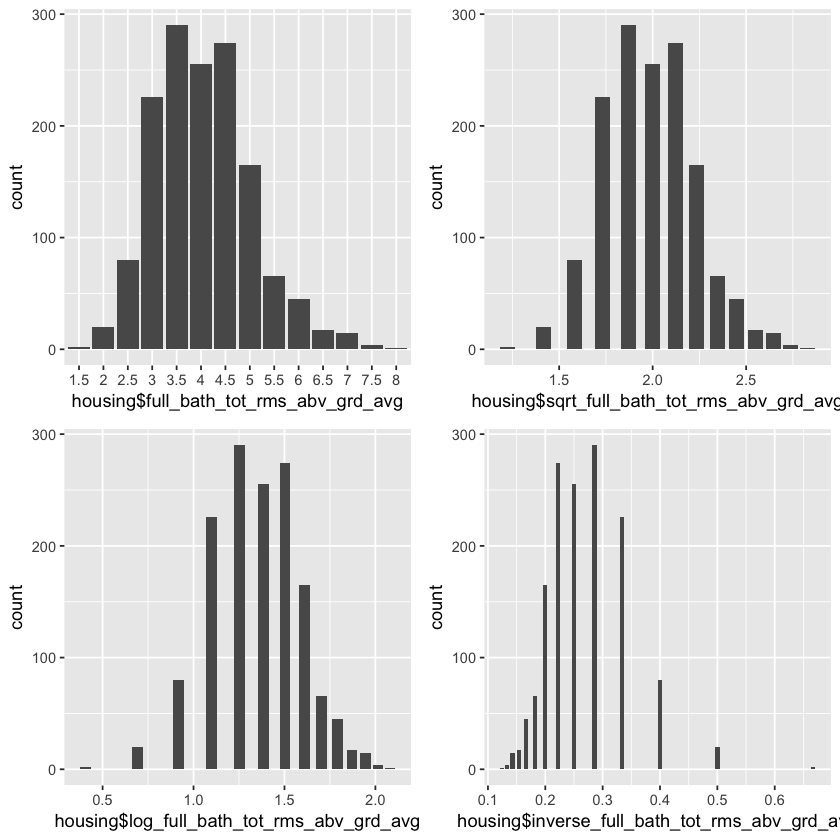

In [118]:
p11 <- ggplot(data= housing, aes(housing$log_full_bath_tot_rms_abv_grd_avg)) + geom_bar()
p12 <- ggplot(data= housing, aes(housing$sqrt_full_bath_tot_rms_abv_grd_avg)) + geom_bar()
p13 <- ggplot(data= housing, aes(housing$inverse_full_bath_tot_rms_abv_grd_avg)) + geom_bar()
multiplot(p3, p11, p12, p13, cols = 2)

In [219]:
ncol(X)
ncol(A)

[1] 38

[1] 38

In [126]:
#a <- housing_w_dummy_vars[sapply(housing_w_dummy_vars, is.numeric)]